# Complete Workflow for generating ATS input for Coweeta

This workflow provides a complete working example to develop an unstructured mesh for an integrated hydrologic model based on HUCs.  It is the default workflow for integrated hydrology simulations for Exasheds Simulation Campaign 2.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

Given some basic inputs (in the next cell) including a NAME, this workflow creates the following files (noting that some suffixes may be appended to the user-provided NAME in homogeneous cases):

* Mesh file: `{NAME}.exo`, includes all labeled sets
* Forcing: DayMet data -- daily raster of precip, RH, incoming radiation, etc.
  - `{NAME}_DayMet_1910_2020.h5`, the DayMet data on this watershed
  - `{NAME}_DayMet_typical_1910_2020.h5`, a "typical year" of DayMet, smoothed for spinup purposes, then looped 40 years
* Forcing: LAI data -- every 4 days, time series by land cover type of LAI.  Note, the raw inputs to this are not done by NAME, but by an (optional, defaults to NAME) MODIS_NAME variable.  Since WW does not currently download MODIS, one might want to use a file of a different name to provide MODIS data.  The times of this MODIS data are hard-coded too -- this is all a bit wonky and will remain so until we get around to adding a file manager for MODIS data.
  - `{NAME}_MODIS_LAI_smoothed_2010_2020.h5`, the LAI, interpolated and smoothed from the raw MODIS data
  - `{NAME}_MODIS_LAI_typical_2010_2020.h5`, a "typical year" of LAI, smoothed for spinup purposes then looped 10 years
* Input files: ATS xml files
  - `spinup-steadystate-{NAME}.xml` the steady-state solution based on uniform application of mean rainfall rate
  - `spinup-cyclic_steadystate-{NAME}.xml` the cyclic steady state based on typical years
  - `transient-{NAME}.xml` the forward model


In [1]:
# these can be turned on for development work
%load_ext autoreload
%autoreload 2

In [2]:
import netCDF4

In [3]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas as pd
import geopandas as gpd
import cftime, datetime
pd.options.display.max_columns = None

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.daymet
import watershed_workflow.land_cover_properties
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.io
import watershed_workflow.sources.standard_names as names

import ats_input_spec
import ats_input_spec.public
import ats_input_spec.io

import amanzi_xml.utils.io as aio
import amanzi_xml.utils.search as asearch
import amanzi_xml.utils.errors as aerrors

watershed_workflow.ui.setup_logging(1, None)
figsize = (6,6)
figsize_3d = (8,6)


## Parameters and data sources

In [4]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
name = 'Coweeta'
coweeta_shapefile = os.path.join('input_data', 'coweeta_basin.shp')
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape

figsize = (6,6)
figsize_3d = (8,6)

# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
simplify = 60 # length scale to target average edge
ignore_small_rivers = 2 
prune_by_area_fraction = 0.01 


# simulation control
start = datetime.date(2010,8,1)
end = datetime.date(2011,8,1)
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils
nyears_cyclic_steadystate = 4

# triangle refinement control
include_rivers = True
# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200
refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

# soil structure
use_geologic_layer = True

# logistics
generate_plots = True # plots take time to make and aren't always needed
generate_daymet = True # potentially don't do Met data forcing
generate_modis = True

log_to_file = False  # if true, write to file instead of in the notebook output


In [5]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start.year >= 1980 and end.year < 2023)


In [6]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [7]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

In [8]:
# get the shape and crs of the shape
coweeta = watershed_workflow.getShapes(coweeta_shapefile, crs=crs)
coweeta.rename(columns={'AREA' : names.AREA, 'LABEL' : names.NAME}, inplace=True)
coweeta[names.ID] = coweeta.index.values
coweeta.set_index(names.ID, inplace=True, drop=True)

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile. A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [9]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.getDefaultSources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDPlus HR']
sources['HUC'] = watershed_workflow.source_list.huc_sources['WaterData WBD']

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
lc_file = ['input_data', 'land_cover', 'land_cover.tif']
dtb_file = ['input_data', 'DTB', 'DTB.tif']
geo_file = ['input_data', 'GLHYMPS', 'GLHYMPS.shp']
if os.path.split(os.getcwd())[-1] == 'examples':
    lc_file.insert(0, 'Coweeta')
    dtb_file.insert(0, 'Coweeta')
    geo_file.insert(0, 'Coweeta')

sources['land cover'] = watershed_workflow.source_list.ManagerRaster(os.path.join(*lc_file))
sources['geologic structure'] = watershed_workflow.source_list.ManagerGLHYMPS(os.path.join(*geo_file))

#
# the Pelletier DTB map is not particularly accurate at Coweeta -- the SoilGrids map seems to be better.  Here we will use a clipped version of that map
sources['depth to bedrock'] = watershed_workflow.source_list.ManagerRaster(os.path.join(*dtb_file))
watershed_workflow.source_list.logSources(sources)

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

<Axes: >

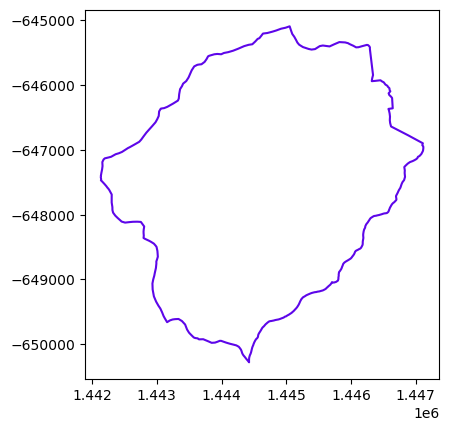

In [10]:
watershed = watershed_workflow.split_hucs.SplitHUCs(coweeta)
watershed.plot()

### Get Rivers 

In [11]:
include_rivers = True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    reaches = watershed_workflow.getShapesByGeometry(sources['hydrography'], watershed.exterior, crs, crs)
    rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers

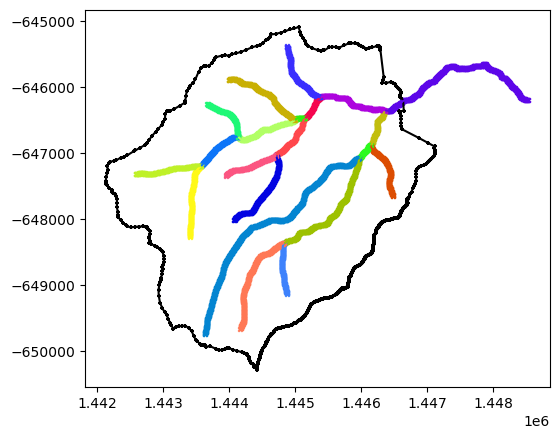

In [12]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In [13]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]
    
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 75, 75, 100, 500)

# greatly shrunk the rivers... shrink the dataframe too
for river in rivers:
    river.resetDataFrame()

# Now that the river network is set, find the watershed boundary outlets
for river in rivers:
    watershed_workflow.hydrography.findOutletsByCrossings(watershed, river)

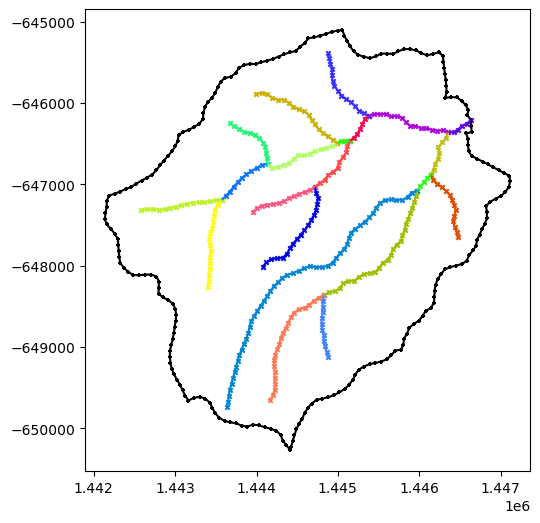

In [14]:
plot(watershed, rivers)

In [15]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
# m = watershed_workflow.makeMap(m)
m

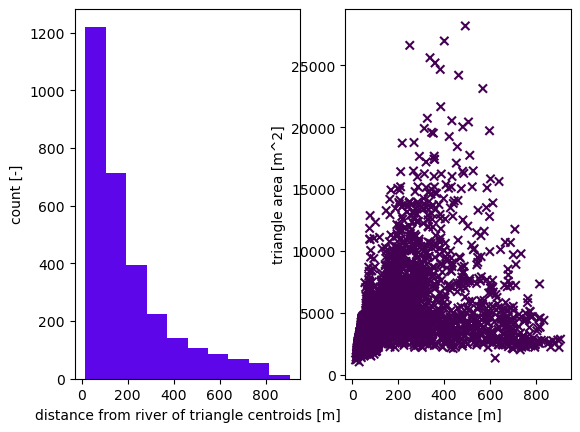

In [16]:
## Triangulation

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

m2, areas, dists = watershed_workflow.tessalateRiverAligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle,refine_max_area=30000,
                                              diagnostics=True)

In [17]:
# get a raster for the elevation map, based on NED
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# provide surface mesh elevations
watershed_workflow.elevate(m2, dem)

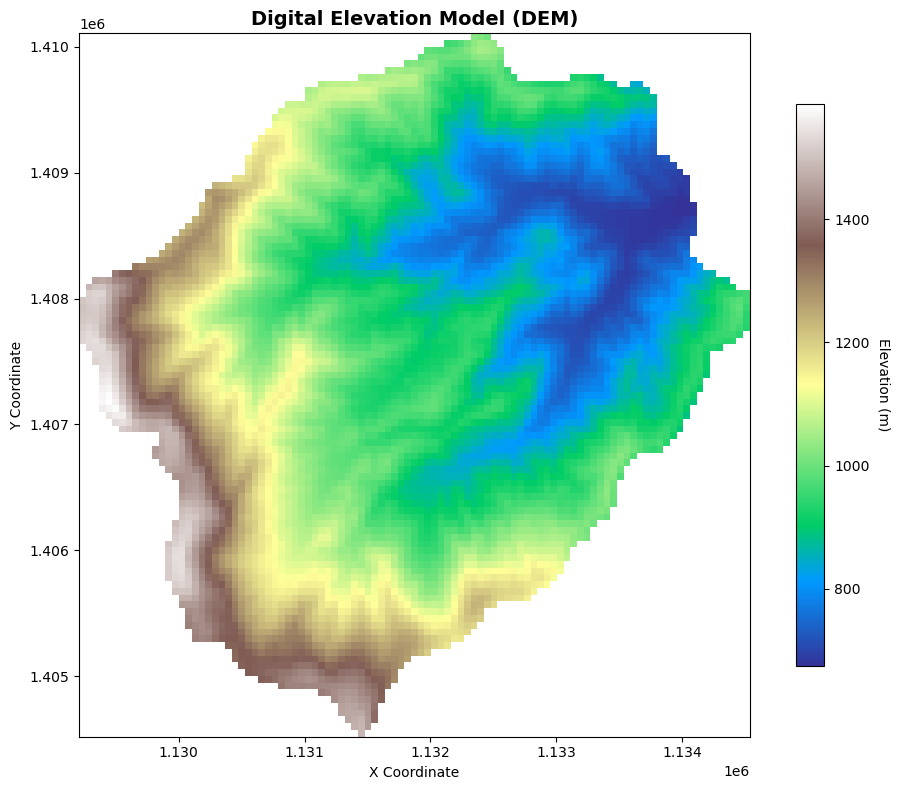

In [18]:
import matplotlib.pyplot as plt

# Plot the DEM raster
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the DEM data
im = dem.plot(ax=ax, cmap='terrain', add_colorbar=False)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Elevation (m)', rotation=270, labelpad=15)

# Add title and labels
ax.set_title('Digital Elevation Model (DEM)', fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set equal aspect ratio
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In the pit-filling algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [19]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fillPitsDual(m2, is_waterbody=river_mask)

There are a range of options to condition river corridor mesh. We hydrologically condition the river mesh, ensuring unimpeded water flow in river corridors by globally adjusting flowlines to rectify artificial obstructions from inconsistent DEM elevations or misalignments. Please read the documentation for more information


In [20]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.setProfileByDEM(rivers, dem)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.conditionRiverMesh(m2, rivers[0])

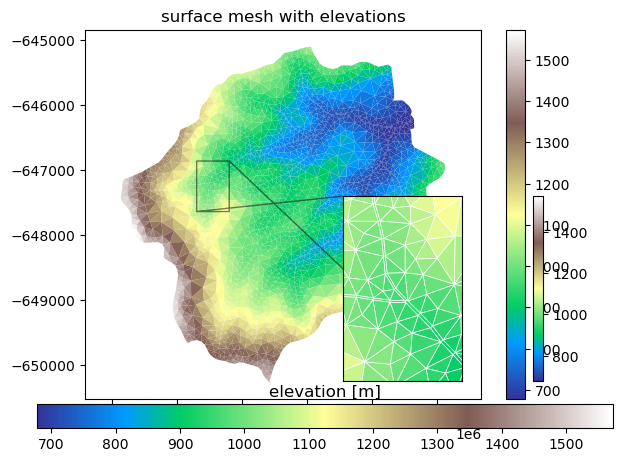

In [21]:
# plotting surface mesh with elevations
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = m2.plot(facecolors='elevation', edgecolors=None, ax=ax, linewidth=0.5)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', edgecolors='white', ax=ax2)
ax2.set_aspect('equal', 'datalim')

xlim = (1.4433e6, 1.4438e6)
ylim = (-647000, -647500)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


In [22]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.addWatershedAndOutletRegions(m2, watershed, outlet_width=250, exterior_outlet=True)

# add labeled sets for river corridor cells
watershed_workflow.regions.addRiverCorridorRegions(m2, rivers)

# add labeled sets for river corridor cells by order
watershed_workflow.regions.addStreamOrderRegions(m2, rivers)

In [23]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 3324 : "Coweeta Hydrologic Lab"
10001 : CELL : 3324 : "Coweeta Hydrologic Lab surface"
10002 : FACE : 227 : "Coweeta Hydrologic Lab boundary"
10003 : FACE : 9 : "Coweeta Hydrologic Lab outlet"
10004 : FACE : 9 : "surface domain outlet"
10005 : CELL : 300 : "river corridor 0 surface"
10006 : CELL : 26 : "stream order 3"
10007 : CELL : 74 : "stream order 2"
10008 : CELL : 200 : "stream order 1"


## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

## NLCD for LULC

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [24]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs, band=1)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(82), np.uint8(90)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.8862745098, 0.8862745098, 0.7568627451), (0.85882352941, 0.84705882353, 0.23921568628), (0.66666666667, 0.43921568628, 0.1568627451), (0.72941176471, 0.84705882353, 0.91764705882)]


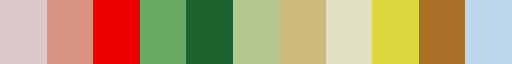

In [25]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

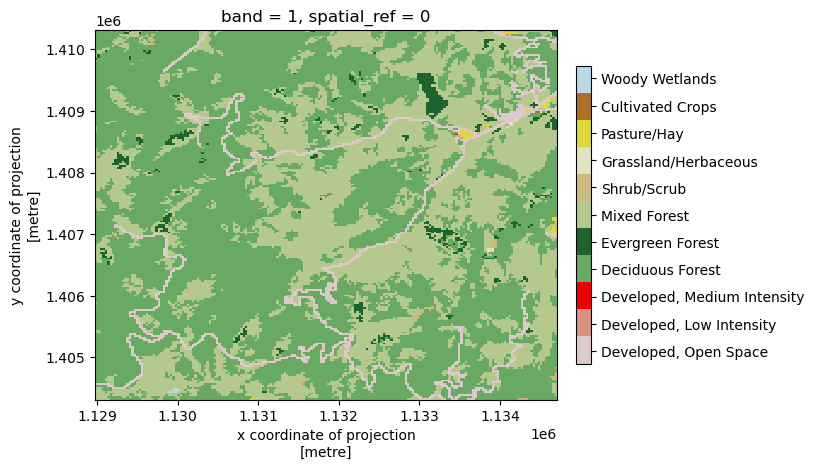

In [26]:
fig, ax = plt.subplots(1,1)
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
plt.show()

In [27]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data = pd.DataFrame({'land_cover': m2_nlcd})

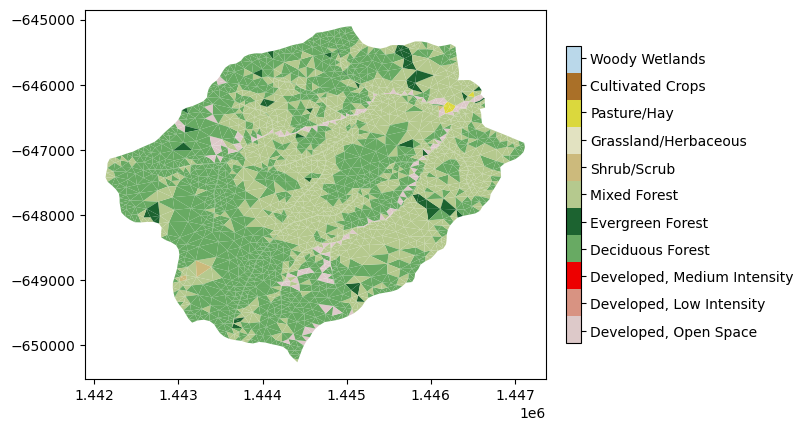

In [28]:
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=plt.gca()) 
plt.show()

In [29]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [30]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 3324 : "Coweeta Hydrologic Lab"
10001 : CELL : 3324 : "Coweeta Hydrologic Lab surface"
10002 : FACE : 227 : "Coweeta Hydrologic Lab boundary"
10003 : FACE : 9 : "Coweeta Hydrologic Lab outlet"
10004 : FACE : 9 : "surface domain outlet"
10005 : CELL : 300 : "river corridor 0 surface"
10006 : CELL : 26 : "stream order 3"
10007 : CELL : 74 : "stream order 2"
10008 : CELL : 200 : "stream order 1"
21 : CELL : 158 : "Developed, Open Space"
41 : CELL : 1646 : "Deciduous Forest"
42 : CELL : 54 : "Evergreen Forest"
43 : CELL : 1454 : "Mixed Forest"
52 : CELL : 4 : "Shrub/Scrub"
81 : CELL : 8 : "Pasture/Hay"


## MODIS LAI

In [31]:
startdate = start #f'{start_year}-01-01'
enddate = end #f'{end_year+1}-01-01'
res = sources['LAI'].getDataset(watershed.exterior.bounds, crs, startdate, enddate)


In [32]:
if isinstance(res, watershed_workflow.sources.manager_modis_appeears.Task):
    assert sources['LAI'].is_ready(res)
    modis_data = sources['LAI'].getDataset(task=res)
else:
    modis_data = res

assert modis_data['LAI'].rio.crs is not None
print(modis_data['LULC'].rio.crs, modis_data['LULC'].dtype)


EPSG:4269 float32


In [33]:
# remove leap day (366th day of any leap year)
for k,v in modis_data.items():
    assert v.rio.crs is not None
    new_v = watershed_workflow.data.filterLeapDay(v)
    assert new_v.rio.crs is not None
    modis_data[k] = new_v


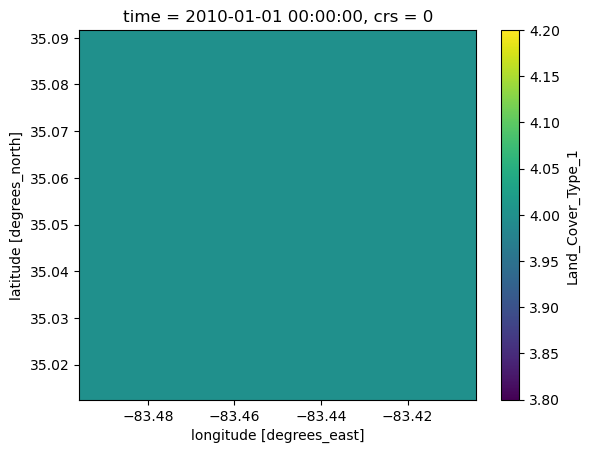

In [34]:
modis_data['LULC'][0].plot.imshow()

In [35]:
# need new start and end dates in the new calendar
startdate = start 
enddate = end 

# compute the dynamic time series
lai_df = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

In [36]:
lai_df

,time [datetime],Deciduous Broadleaf Forests LAI [-]
0,2010-08-01 00:00:00,3.221277
1,2010-08-05 00:00:00,4.808511
2,2010-08-09 00:00:00,3.442553
3,2010-08-13 00:00:00,4.211702
4,2010-08-17 00:00:00,3.159574
...,...,...
88,2011-07-16 00:00:00,6.364894
89,2011-07-20 00:00:00,4.693617
90,2011-07-24 00:00:00,4.148936
91,2011-07-28 00:00:00,5.281915


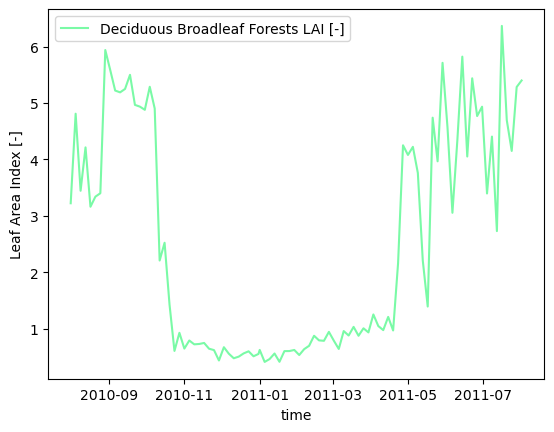

In [37]:
outputs['modis_lai_dynamic'] = f'{name}_LAI_MODIS_Dynamic.h5'
watershed_workflow.io.writeTimeseriesToHDF5(outputs['modis_lai_dynamic'], lai_df)
watershed_workflow.land_cover_properties.plotLAI(lai_df, indices='MODIS')

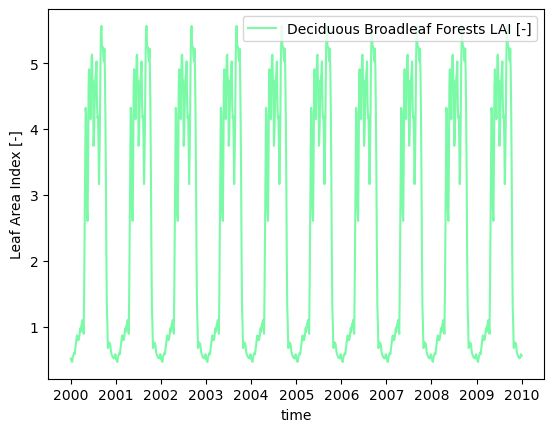

In [38]:
lai_smoothed = watershed_workflow.data.smoothTimeSeries(lai_df, 'time [datetime]')
lai_typical_df = watershed_workflow.data.computeAverageYear(lai_smoothed, 'time [datetime]', output_nyears=10, 
                                                                  start_year=2000)


outputs['modis_lai_cyclic_steadystate'] = f'{name}_LAI_MODIS_CyclicSteadystate.h5'
watershed_workflow.io.writeTimeseriesToHDF5(outputs['modis_lai_cyclic_steadystate'], lai_typical_df)
watershed_workflow.land_cover_properties.plotLAI(lai_typical_df, indices='MODIS')

## Crosswalk of LAI to NLCD LC

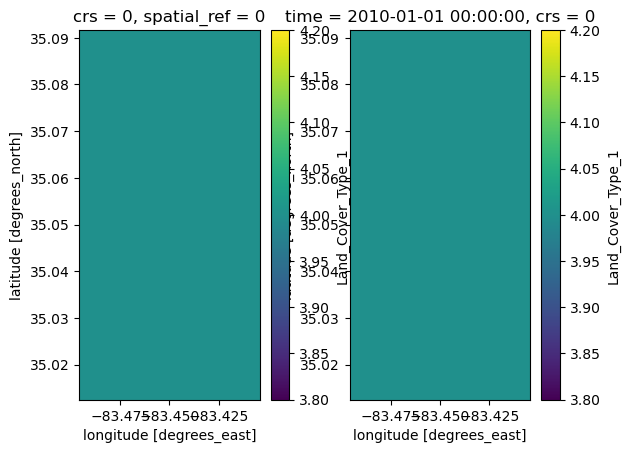

In [39]:
modis_lulc_mode = watershed_workflow.data.computeMode(modis_data['LULC'])

fig, ax = plt.subplots(1,2)
modis_lulc_mode.plot.imshow(ax=ax[0])
modis_data['LULC'][0].plot.imshow(ax=ax[1])
plt.show()

In [40]:
print(watershed_workflow.crs.from_xarray(modis_data['LULC']))
print(watershed_workflow.crs.from_xarray(modis_lulc_mode))

EPSG:4269
EPSG:4269


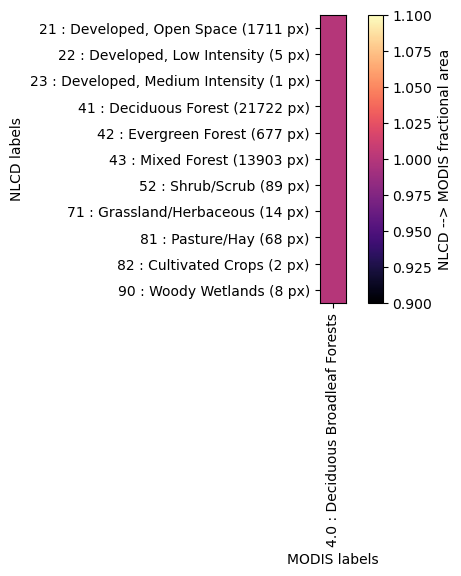

In [41]:
crosswalk = watershed_workflow.land_cover_properties.computeCrosswalk(modis_lulc_mode, nlcd, method='fractional area')

In [42]:
# Compute the NLCD-based time series
nlcd_lai_cyclic_steadystate = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, lai_typical_df)
nlcd_lai_dynamic = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, lai_df)

watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_cyclic_steadystate)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_dynamic)
nlcd_lai_dynamic

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False
None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time [datetime],"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]",Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-],Cultivated Crops LAI [-],Woody Wetlands LAI [-]
0,2010-08-01 00:00:00,3.221277,3.221277,0.0,3.221277,3.221277,3.221277,3.221277,3.221277,3.221277,3.221277,3.221277
1,2010-08-05 00:00:00,4.808511,4.808511,0.0,4.808511,4.808511,4.808511,4.808511,4.808511,4.808511,4.808511,4.808511
2,2010-08-09 00:00:00,3.442553,3.442553,0.0,3.442553,3.442553,3.442553,3.442553,3.442553,3.442553,3.442553,3.442553
3,2010-08-13 00:00:00,4.211702,4.211702,0.0,4.211702,4.211702,4.211702,4.211702,4.211702,4.211702,4.211702,4.211702
4,2010-08-17 00:00:00,3.159574,3.159574,0.0,3.159574,3.159574,3.159574,3.159574,3.159574,3.159574,3.159574,3.159574
...,...,...,...,...,...,...,...,...,...,...,...,...
88,2011-07-16 00:00:00,6.364894,6.364894,0.0,6.364894,6.364894,6.364894,6.364894,6.364894,6.364894,6.364894,6.364894
89,2011-07-20 00:00:00,4.693617,4.693617,0.0,4.693617,4.693617,4.693617,4.693617,4.693617,4.693617,4.693617,4.693617
90,2011-07-24 00:00:00,4.148936,4.148936,0.0,4.148936,4.148936,4.148936,4.148936,4.148936,4.148936,4.148936,4.148936
91,2011-07-28 00:00:00,5.281915,5.281915,0.0,5.281915,5.281915,5.281915,5.281915,5.281915,5.281915,5.281915,5.281915


In [43]:
# write the NLCD-based time series to disk
outputs['nlcd_lai_cyclic_steadystate'] = f'{name}_LAI_NLCD_CyclicSteadystate.h5'
watershed_workflow.io.writeTimeseriesToHDF5(outputs['nlcd_lai_cyclic_steadystate'], nlcd_lai_cyclic_steadystate)

outputs['nlcd_lai_dynamic'] = f'{name}_LAI_NLCD_Dynamic.h5'
watershed_workflow.io.writeTimeseriesToHDF5(outputs['nlcd_lai_dynamic'], nlcd_lai_dynamic)

# Subsurface Soil, Geologic Structure

## NRCS Soils

In [44]:
# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watershed.exterior, watershed.crs).to_crs(crs)


In [45]:
nrcs

,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID,name
0,545800,"MULTIPOLYGON (((1444323.547 -650276.667, 14443...",0.177165,0.431041,0.000139,1.470755,8.079687e-13,2.03,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS,545800,NRCS-545800
1,545801,"MULTIPOLYGON (((1442409.341 -648205.513, 14423...",0.177493,0.432741,0.000139,1.469513,8.184952e-13,2.03,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS,545801,NRCS-545801
2,545803,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",0.172412,0.400889,0.000150,1.491087,6.477202e-13,2.03,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS,545803,NRCS-545803
3,545805,"MULTIPOLYGON (((1447162.174 -649688.276, 14471...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545805,NRCS-545805
4,545806,"MULTIPOLYGON (((1447116.743 -649609.716, 14471...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545806,NRCS-545806
5,545807,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545807,NRCS-545807
6,545811,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545811,NRCS-545811
7,545812,"POLYGON ((1443088.752 -650445.293, 1443072.215...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545812,NRCS-545812
8,545813,"MULTIPOLYGON (((1445736.174 -649979.838, 14457...",0.183468,0.398767,0.000127,1.445858,4.296896e-13,2.03,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS,545813,NRCS-545813
9,545814,"MULTIPOLYGON (((1447457.959 -649645.07, 144747...",0.183216,0.399168,0.000125,1.445793,4.285058e-13,2.03,6.060887e-14,0.346424,1.406875,59.510029,26.771221,13.718750,NRCS,545814,NRCS-545814


In [46]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
name                           False
dtype: bool

In [47]:
# Compute the soil color of each cell of the mesh
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'ID', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('ID', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))
if -999 in unique_soil_colors:
    unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.ID, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


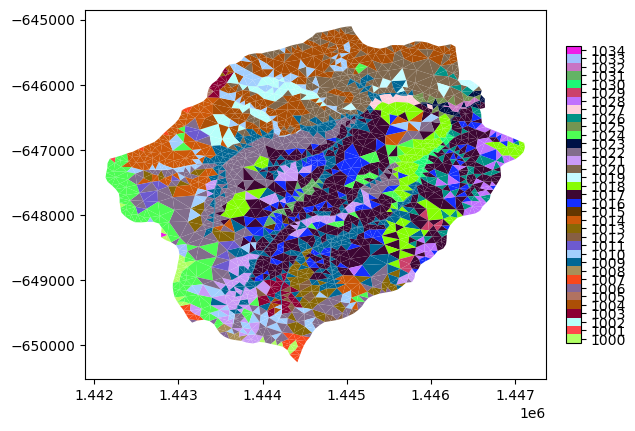

In [48]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

## Depth to Bedrock from SoilGrids

In [49]:
dtb = sources['depth to bedrock'].getDataset(watershed.exterior, watershed.crs)

# the SoilGrids dataset is in cm --> convert to meters
dtb.values = dtb.values/100.

In [50]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


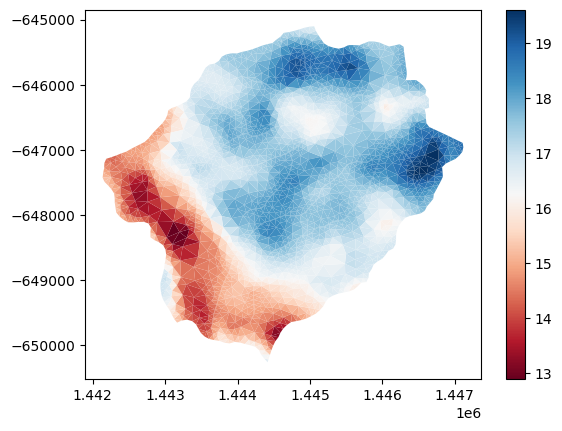

In [51]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

## GLHYMPs Geology

In [52]:
glhymps = sources['geologic structure'].getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, 
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# convert to the right geometry (this should be done in a call to ww.getShapesByGeometry()!
glhymps = glhymps.to_crs(watershed.crs)

# intersect with the buffered geometry -- don't keep extras
glhymps = glhymps[glhymps.intersects(watershed.exterior.buffer(10))]
glhymps

,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,,
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [53]:
# quality check -- make sure glymps shapes cover the watershed
print(glhymps.union_all().contains(watershed.exterior))
glhymps

True


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,,
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [54]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

ID                             False
name                           False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [55]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(glhymps, 'ID')
glhymps

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [56]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [57]:
geology_color_glhymps.min()

np.int64(0)

## Combine to form a complete subsurface dataset

In [58]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
outputs['subsurface_properties_filename'] = os.path.join(f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(outputs['subsurface_properties_filename'])
subsurface_props


,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015....",NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444323.547 -650276.667, 14443...",545800.0,2.03
1001,545801,NRCS-545801,NRCS,3.247236e-15,0.303714,0.000139,1.469513,0.177493,"MULTIPOLYGON (((1442409.341 -648205.513, 14423...",545801.0,2.03
1002,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",545803.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447116.743 -649609.716, 14471...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445736.174 -649979.838, 14457...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1447457.959 -649645.07, 144747...",545814.0,2.03
1008,545815,NRCS-545815,NRCS,3.794887e-14,0.319402,0.000162,1.498482,0.177808,"MULTIPOLYGON (((1443279.319 -650491.203, 14432...",545815.0,2.03


# Extrude the 2D Mesh to make a 3D mesh

In [59]:
# set the floor of the domain as max DTB
dtb_max = np.nanmax(m2.cell_data['dtb'].values)
m2.cell_data['dtb'] = m2.cell_data['dtb'].fillna(dtb_max)

print(f'total thickness: {dtb_max} m')
total_thickness = 50.


total thickness: 19.61778128678484 m


In [60]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimizeDzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.05447108 0.07161305 0.11027281 0.17443206 0.26441087 0.36782677
 0.45697337 0.49999999]
2.0000000000000004


In [61]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [62]:
# 50m total thickness, minus 2m soil thickness, leaves us with 48 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimizeDzs(1, 10, 48, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 2.0, 4.0, 8.0, 11, 11, 11]
print(dzs_geo)
print(sum(dzs_geo))

[2.71113048 5.85796948 9.43304714 9.99786869 9.99998875 9.99999546]
48.0
[1.0, 2.0, 4.0, 8.0, 11, 11, 11]
48.0


In [63]:
# layer extrusion
DTB = m2.cell_data['dtb'].values
soil_color = m2.cell_data['soil_color'].values
geo_color = m2.cell_data['geology_color'].values
soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # use glhymps params
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)

    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    geo_or_br = np.where(depth < DTB, geo_color, 999)

    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
subsurface_props_used


,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015....",NaN,NaN
999,999,bedrock,n/a,1.000000e-16,0.050000,0.000019,3.000000,0.010000,None,NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444323.547 -650276.667, 14443...",545800.0,2.03
1001,545801,NRCS-545801,NRCS,3.247236e-15,0.303714,0.000139,1.469513,0.177493,"MULTIPOLYGON (((1442409.341 -648205.513, 14423...",545801.0,2.03
1002,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",545803.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447116.743 -649609.716, 14471...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445736.174 -649979.838, 14457...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1447457.959 -649645.07, 144747...",545814.0,2.03


In [64]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [65]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    

2D labeled sets
---------------
10000 : CELL : 3324 : "Coweeta Hydrologic Lab"
10001 : CELL : 3324 : "Coweeta Hydrologic Lab surface"
10002 : FACE : 227 : "Coweeta Hydrologic Lab boundary"
10003 : FACE : 9 : "Coweeta Hydrologic Lab outlet"
10004 : FACE : 9 : "surface domain outlet"
10005 : CELL : 300 : "river corridor 0 surface"
10006 : CELL : 26 : "stream order 3"
10007 : CELL : 74 : "stream order 2"
10008 : CELL : 200 : "stream order 1"
21 : CELL : 158 : "Developed, Open Space"
41 : CELL : 1646 : "Deciduous Forest"
42 : CELL : 54 : "Evergreen Forest"
43 : CELL : 1454 : "Mixed Forest"
52 : CELL : 4 : "Shrub/Scrub"
81 : CELL : 8 : "Pasture/Hay"

Extruded 3D labeled sets
------------------------
10000 : CELL : 49860 : "Coweeta Hydrologic Lab"

Extruded 3D side sets
---------------------
1 : FACE : 3324 : "bottom"
2 : FACE : 3324 : "surface"
3 : FACE : 3405 : "external_sides"
10001 : FACE : 3324 : "Coweeta Hydrologic Lab surface"
10002 : FACE : 3405 : "Coweeta Hydrologic Lab boundary"
10

In [66]:
# save the mesh to disk
outputs['mesh_filename'] = os.path.join('output_data',f'{name}.exo')
try:
    os.remove(outputs['mesh_filename'])
except FileNotFoundError:
    pass
# m3.writeExodus(outputs['mesh_filename'])

## Meteorological forcing dataset

In addition to the LAI covered above, ATS is driven by meteorological forcing data. We need two forcing datasets -- the actual time series and a typical year for use in spinup.

In [67]:
startdate = cftime.datetime(start.year, start.month, start.day, calendar='noleap')
enddate = cftime.datetime(end.year, end.month, end.day, calendar='noleap')

# download the data
met_data_raw = sources['meteorology'].getDataset(watershed.exterior, crs, startdate, enddate)

# write raw data to HDF5
filename = os.path.join('output_data', f'{name}_daymet-raw.h5')
outputs['meteorology_raw'] = filename
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_raw, 
    watershed_workflow.daymet.getAttributes(watershed.exterior.bounds, startdate, enddate))

In [68]:
# convert and write ATS format for transient run
met_data_transient = watershed_workflow.daymet.convertToATS(met_data_raw)


Text(0, 0.5, 'incoming shortwave radiation [W m^-2]')

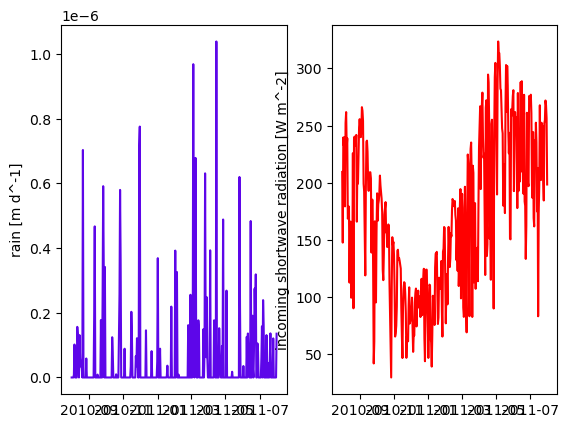

In [69]:
# plot a few of the met data -- does it look reasonable?
date = np.array([datetime.datetime(t.year, t.month, t.day) for t in met_data_transient.time.values])
            
fig, axs = plt.subplots(1,2)
axs[0].plot(date, met_data_transient['precipitation rain [m s^-1]'].data[:,5,5])
axs[0].set_ylabel('rain [m d^-1]')

axs[1].plot(date, met_data_transient['incoming shortwave radiation [W m^-2]'].data[:,5,5], 'r')
axs[1].set_ylabel('incoming shortwave radiation [W m^-2]')

In [70]:
# write transient data to disk
filename = os.path.join('output_data', f'{name}_daymet-{start.year}-{end.year}.h5')
outputs['transient meteorology'] = filename
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_transient,
    watershed_workflow.daymet.getAttributes(watershed.exterior.bounds, startdate, enddate))

In [71]:
# compute the typical year of the _raw_ data
# note that we set interpolate to False, since met_data is already daily on a noleap calendar
met_data_raw_avg = watershed_workflow.data.computeAverageYear(met_data_raw, time_column = 'time', start_year = start.year, output_nyears=nyears_cyclic_steadystate)

# smoothing precipitation doesn't work -- even averaging precip doesn't work because both result in more events of lower
# intensity.  Instead, we pick the median year and repeat that nyears_cyclic_steadystate times
precip_raw = met_data_raw['prcp'].data
shape_xy = precip_raw.shape[1:]
precip_raw = precip_raw.reshape((-1, 365,)+shape_xy)
annual_precip_raw = precip_raw.sum(axis=(1,2,3))

# note -- don't use np.median here... for even number of years it will not appear.  Instead, sort and talk the halfway point
median_i = sorted(((i,v) for (i,v) in enumerate(annual_precip_raw)), key=lambda x : x[1])[len(annual_precip_raw)//2][0]
typical_precip_raw = precip_raw[median_i]
met_data_raw_avg['prcp'] = (('time', 'y', 'x'), np.tile(typical_precip_raw, (nyears_cyclic_steadystate,1,1)))


In [72]:
# convert the typical year to ATS
met_data_avg = watershed_workflow.daymet.convertToATS(met_data_raw_avg)

Text(0, 0.5, 'incoming shortwave radiation [W m^-2]')

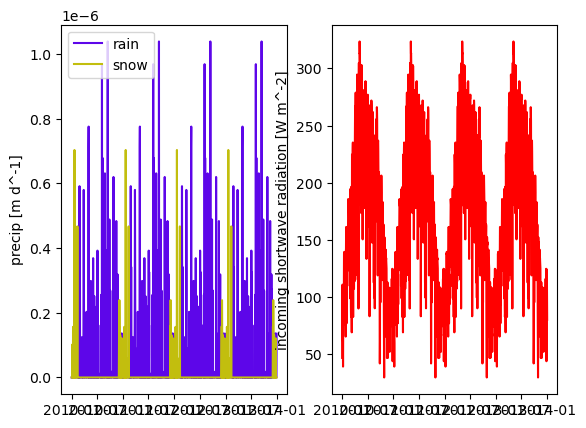

In [73]:
# plot a few of the met data -- does it look reasonable?
fig, axs = plt.subplots(1,2)
date = np.array([datetime.datetime(t.year, t.month, t.day) for t in met_data_avg.time.values])

axs[0].plot(date, met_data_avg['precipitation rain [m s^-1]'].data[:,5,5], label='rain')
axs[0].plot(date, met_data_avg['precipitation snow [m SWE s^-1]'].data[:,5,5], label='snow')
axs[0].legend()
axs[0].set_ylabel('precip [m d^-1]')

axs[1].plot(date, met_data_avg['incoming shortwave radiation [W m^-2]'].data[:,5,5], 'r')
axs[1].set_ylabel('incoming shortwave radiation [W m^-2]')

In [74]:
# write cyclic steadystate data to disk
filename = os.path.join('output_data', f'{name}_daymet-typical.h5')
outputs['cyclic steadystate meteorology'] = filename
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_avg,
    watershed_workflow.daymet.getAttributes(watershed.exterior.bounds, startdate, enddate))


In [75]:
# compute the average precip rate for steadystate solution
precip_mean = (met_data_transient['precipitation rain [m s^-1]'].data + met_data_transient['precipitation snow [m SWE s^-1]'].data).mean()
logging.info(f'Mean precip value = {precip_mean}')


## Write ATS input files

In [76]:
# Note that each of these are defined as functions so we can reuse them for all three input files.

# add the subsurface and surface domains
#
# Note this also adds a "computational domain" region to the region list, and a vis spec 
# for "domain"
def add_domains(main_list, mesh_filename, surface_region='surface', snow=True, canopy=True):
    ats_input_spec.public.add_domain(main_list, 
                                 domain_name='domain', 
                                 dimension=3, 
                                 mesh_type='read mesh file',
                                 mesh_args={'file':mesh_filename})
    if surface_region:
        main_list['mesh']['domain']['build columns from set'] = surface_region    
    
        # Note this also adds a "surface domain" region to the region list and a vis spec for 
        # "surface"
        ats_input_spec.public.add_domain(main_list,
                                domain_name='surface',
                                dimension=2,
                                mesh_type='surface',
                                mesh_args={'surface sideset name':'surface'})
    if snow:
        # Add the snow and canopy domains, which are aliases to the surface
        ats_input_spec.public.add_domain(main_list,
                                domain_name='snow',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})
    if canopy:
        ats_input_spec.public.add_domain(main_list,
                                domain_name='canopy',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})


In [77]:
def add_land_cover(main_list):
    # next write a land-cover section for each NLCD type
    for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
        ats_input_spec.public.set_land_cover_default_constants(main_list, nlcd_name)

    land_cover_list = main_list['state']['initial conditions']['land cover types']
    # update some defaults for
    # ['Other', 'Deciduous Forest']
    # note, these are from the CLM Technical Note v4.5
    #
    # Rooting depth curves from CLM TN 4.5 table 8.3
    #
    # Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
    # curves we are using (ETC -- add paper citation about this topic).  Likely they need
    # to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
    # factor of 10 converts to [Pa]
    #
    # Note, albedo of canopy taken from CLM TN 4.5 table 3.1
    land_cover_list['Deciduous Forest']['rooting profile alpha [-]'] = 6.0
    land_cover_list['Deciduous Forest']['rooting profile beta [-]'] = 2.0
    land_cover_list['Deciduous Forest']['rooting depth max [m]'] = 10.0
    land_cover_list['Deciduous Forest']['capillary pressure at fully closed stomata [Pa]'] = 224000
    land_cover_list['Deciduous Forest']['capillary pressure at fully open stomata [Pa]'] = 35000 * .10
    land_cover_list['Deciduous Forest']['albedo of canopy [-]'] = 0.1



In [78]:
# add soil sets: note we need a way to name the set, so we use, e.g. SSURGO-MUKEY.
def soil_set_name(ats_id):
    return subsurface_props_used.loc[ats_id, 'name']

def add_soil_properties(main_list):
    # add soil material ID regions, porosity, permeability, and WRMs
    for ats_id in subsurface_props_used.index:
        props = subsurface_props_used.loc[ats_id]
        set_name = soil_set_name(ats_id)
        
        if props['van Genuchten n [-]'] < 1.5:
            smoothing_interval = 0.01
        else:
            smoothing_interval = 0.0
        
        ats_input_spec.public.add_soil_type(main_list, set_name, ats_id, outputs['mesh_filename'],
                                            float(props['porosity [-]']),
                                            float(props['permeability [m^2]']), 1.e-7,
                                            float(props['van Genuchten alpha [Pa^-1]']),
                                            float(props['van Genuchten n [-]']),
                                            float(props['residual saturation [-]']),
                                            float(smoothing_interval))    



In [79]:
# get an ATS "main" input spec list -- note, this is a dummy and is not used to write any files yet
def get_main():
    main_list = ats_input_spec.public.get_main()

    # add the mesh and all domains
    mesh_filename = os.path.join('..', outputs['mesh_filename'])
    add_domains(main_list, mesh_filename)

    # add labeled sets
    for ls in m3.labeled_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ls.name, ls.setid, mesh_filename, ls.entity)
    for ss in m3.side_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ss.name, ss.setid, mesh_filename, 'FACE')
    
    # add land cover
    add_land_cover(main_list)

    # add soil properties
    add_soil_properties(main_list)
        
    # add observations for each subcatchment
    ats_input_spec.public.add_observations_water_balance(main_list, "computational domain", 
                                                         "surface domain", "external_sides")

    return main_list


In [80]:
def populate_basic_properties(xml, main_xml):
    """This function updates an xml object with the above properties for mesh, regions, soil props, and lc props"""
    # find and replace the mesh list
    xml.replace('mesh', asearch.child_by_name(main_xml, 'mesh'))

    # find and replace the regions list
    xml.replace('regions', asearch.child_by_name(main_xml, 'regions'))
    
    # update all model parameters lists
    xml_parlist = asearch.find_path(xml, ['state', 'model parameters'], no_skip=True)
    for parlist in asearch.find_path(main_xml, ['state', 'model parameters'], no_skip=True):
        try:
            xml_parlist.replace(parlist.getName(), parlist)
        except aerrors.MissingXMLError:
            xml_parlist.append(parlist)

    # update all evaluator lists
    xml_elist = asearch.find_path(xml, ['state', 'evaluators'], no_skip=True)
    for elist in asearch.find_path(main_xml, ['state', 'evaluators'], no_skip=True):
        try:
            xml_elist.replace(elist.getName(), elist)
        except aerrors.MissingXMLError:
            xml_elist.append(elist)    
    
    # find and replace land cover
    consts_list = asearch.find_path(xml, ['state', 'initial conditions'])
    lc_list = asearch.find_path(main_xml, ['state', 'initial conditions', 'land cover types'], no_skip=True)
    
    try:
        consts_list.replace('land cover types', lc_list)
    except aerrors.MissingXMLError:
        consts_list.append(lc_list)


For the first file, we load a spinup template and write the needed quantities into that file, saving it to the appropriate run directory.  Note there is no DayMet or land cover or LAI properties needed for this run.  The only property that is needed is the domain-averaged, mean annual rainfall rate.  We then take off some for ET (note too wet spins up faster than too dry, so don't take off too much...).

In [81]:
def write_spinup_steadystate(name, precip_mean, **kwargs):
    # create the main list
    main = get_main()

    # set precip to 0.6 * the mean precip value
    precip = main['state']['evaluators'].append_empty('surface-precipitation')
    precip.set_type('independent variable constant', ats_input_spec.public.known_specs['evaluator-independent-variable-constant-spec'])
    precip['value'] = float(precip_mean * .6)

    
    # load the template file
    prefix = 'steadystate'
    xml = aio.fromFile(os.path.join('input_data', f'{prefix}-template.xml'))
    
    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)

    # write to disk
    outputs[f'{prefix}_filename'] = f'{name}-{prefix}.xml'
    filename = outputs[f'{prefix}_filename']
    aio.toFile(xml, filename)

    # create a run directory
    outputs[f'{prefix}_rundir'] = f'{name}-{prefix}'
    rundir = outputs[f'{prefix}_rundir']
    os.makedirs(rundir, exist_ok=True)


For the second file, we load a transient run template.  This file needs the basics, plus DayMet and LAI as the "typical year data".  Also we set the run directory that will be used for the steadystate run.

For the third file, we load a transient run template as well.  This file needs the basics, DayMet with the actual data, and we choose for this run to use the MODIS typical year.  MODIS is only available for 2002 on, so if we didn't need 1980-2002 we could use the real data, but for this run we want a longer record.

In [82]:
def write_transient(name, cyclic_steadystate=False, **kwargs):
    # make a unique name based on options
    logging.info(f'Writing transient: {name}')

    if cyclic_steadystate:
        prefix = 'cyclic_steadystate'
        previous = 'steadystate'
    else:
        prefix = 'transient'
        previous = 'cyclic_steadystate'

    main = get_main()

    # add the DayMet evaluators
    if cyclic_steadystate:
        daymet_filename = outputs['cyclic steadystate meteorology']
    else:
        daymet_filename = outputs['transient meteorology']
    ats_input_spec.public.add_daymet_box_evaluators(main, os.path.join('..', daymet_filename), True)

    # add the LAI filenames
    if cyclic_steadystate:
        lai_filename = outputs['nlcd_lai_cyclic_steadystate']
    else:
        lai_filename = outputs['nlcd_lai_dynamic']
    ats_input_spec.public.add_lai_point_evaluators(main, os.path.join('..', lai_filename), list(nlcd_labels_dict.values()))
    
    # load the template file
    template_filename = os.path.join('input_data', f'{prefix}-template.xml')
    xml = aio.fromFile(template_filename)

    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)
    
    # update the start and end time -- would be nice to set these in main, but it would be 
    # confusing as to when to copy them in populate_basic_properties and when not to do so.
    start_day = 274
    if cyclic_steadystate:
        end_day = 274 + (nyears_cyclic_steadystate - 1) * 365 
    else:
        end_day = 274 + (enddate - startdate).days 
        
    par = asearch.find_path(xml, ['cycle driver', 'start time'])
    par.setValue(start_day)

    par = asearch.find_path(xml, ['cycle driver', 'end time'])
    par.setValue(end_day)
    
    # update the restart filenames
    for var in asearch.findall_path(xml, ['initial condition', 'restart file']):
        var.setValue(os.path.join('..', outputs[f'{previous}_rundir'], 'checkpoint_final.h5'))

    # update the observations list
    obs = next(i for (i,el) in enumerate(xml) if el.get('name') == 'observations')
    xml[obs] = asearch.child_by_name(main_xml, 'observations')
   
    # write to disk and make a directory for running the run
    outputs[f'{prefix}_filename'] = f'{name}-{prefix}.xml'
    filename = outputs[f'{prefix}_filename']

    outputs[f'{prefix}_rundir'] = os.path.join(f'{name}-{prefix}')
    rundir = outputs[f'{prefix}_rundir']

    aio.toFile(xml, filename)
    os.makedirs(rundir, exist_ok=True)

In [83]:
write_spinup_steadystate(name, precip_mean)
write_transient(name, True)
write_transient(name, False)

/home/ecoon/code/ats/ats_input_spec/repos/master/ats_input_spec/io.py:43: UserWarning: Creating an incomplete XML object, missing entries!
  warnings.warn('Creating an incomplete XML object, missing entries!')


In [84]:
logging.info('this workflow is a total success!')